# 0. Installing package

In [1]:
!pip install yfinance -q

# 1. Load package

In [52]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import SimpleRNN, GRU, LSTM, Input, Dense
from tensorflow.keras.models import Model
import plotly.graph_objects as go


# 2. Load dataset
---
The dataset was obtained from the Yahoo Finance package, specifically focusing on Intel Corporation. By replacing the company code (`INTC`) with the respective company code of interest, we can access data for other companies as well.


In [4]:
import yfinance as yf

company_id = 'INTC'
stock_data = yf.download(company_id)
print(stock_data)

[*********************100%%**********************]  1 of 1 completed

                 Open       High        Low      Close  Adj Close    Volume
Date                                                                       
1980-03-17   0.325521   0.330729   0.325521   0.325521   0.183393  10924800
1980-03-18   0.325521   0.328125   0.322917   0.322917   0.181926  17068800
1980-03-19   0.330729   0.335938   0.330729   0.330729   0.186327  18508800
1980-03-20   0.330729   0.334635   0.329427   0.329427   0.185594  11174400
1980-03-21   0.322917   0.322917   0.317708   0.317708   0.178991  12172800
...               ...        ...        ...        ...        ...       ...
2024-04-01  44.290001  45.410000  44.180000  44.520000  44.520000  31712600
2024-04-02  43.930000  44.080002  43.500000  43.939999  43.939999  32748400
2024-04-03  41.400002  41.650002  40.220001  40.330002  40.330002  83718000
2024-04-04  40.590000  40.779999  39.700001  39.730000  39.730000  57307200
2024-04-05  39.349998  39.459999  38.509998  38.709999  38.709999  67189100

[11107 rows

In [5]:
#load dataset into pandas
df = pd.DataFrame(stock_data)
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1980-03-17,0.325521,0.330729,0.325521,0.325521,0.183393,10924800
1980-03-18,0.325521,0.328125,0.322917,0.322917,0.181926,17068800
1980-03-19,0.330729,0.335938,0.330729,0.330729,0.186327,18508800
1980-03-20,0.330729,0.334635,0.329427,0.329427,0.185594,11174400
1980-03-21,0.322917,0.322917,0.317708,0.317708,0.178991,12172800


# 3. Exploratory Data Analysis

In [6]:
# there are 11.107 samples from 17th march 1980 until today (8th April 2024)
df.shape

(11107, 6)

In [8]:
'''there are 6 columns, with each means
1. Open: This is the price of the stock at the beginning of the trading period (e.g., the opening price).
2. High: This represents the highest price at which the stock traded during the trading period.
3. Low: This represents the lowest price at which the stock traded during the trading period.
4. Close: This is the price of the stock at the end of the trading period (e.g., the closing price).
5. Adj Close: This is the adjusted closing price, which takes into account any corporate actions that may have occurred, such as dividends, stock splits, or mergers. It is useful for calculating returns accurately over time.
6. Volume: This represents the total number of shares traded during the trading period.'''
df.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

In [13]:
fig1 = px.line(df, x = df.index, y = 'Adj Close', title = 'Adjusted close price of stock over time')
fig1.show()

In [16]:
# due to the df['Adj Close] is 1 dimensional shape we need ti change it into 3 dimensional shape
# comprised of n_samples, n_days_to_predict (T), 1
# example: if we want to use 5 days to predict the 6th days means that the T is 5
def formatting(data,T):
  X = []
  y = []
  T = T
  D = 1
  for i in range (0, len(data)-T):
    X.append(data[i:i+T])
    y.append(data[i+T])
  X = np.array(X)
  y = np.array(y)
  N = len(X)
  X = X.reshape(-1,T,D)
  return X, y, N

In [147]:
# we are using 30 days to rpedict the 6th days and using Adj Close.
T = 30
x, y, n_samples = formatting(df['Adj Close'], T)

In [24]:
df['Adj Close'].head(6)

Date
1980-03-17    0.183393
1980-03-18    0.181926
1980-03-19    0.186327
1980-03-20    0.185594
1980-03-21    0.178991
1980-03-24    0.175324
Name: Adj Close, dtype: float64

In [148]:
# we are using 30 days to predict the 6th days
print(x[0])
print(y[0])

[[0.18339296]
 [0.18192597]
 [0.18632707]
 [0.18559363]
 [0.17899124]
 [0.17532355]
 [0.17605717]
 [0.17459014]
 [0.16872133]
 [0.17532355]
 [0.18119234]
 [0.18192597]
 [0.18339296]
 [0.17972477]
 [0.17532355]
 [0.17605717]
 [0.17238955]
 [0.17165612]
 [0.17165612]
 [0.17312312]
 [0.17092197]
 [0.16432023]
 [0.16138558]
 [0.16358671]
 [0.16211909]
 [0.16945502]
 [0.17972477]
 [0.18045884]
 [0.17752425]
 [0.17605717]]
0.17752425372600555


In [149]:
#defining the train and test set
def test_size(x,y,n, n_samples):
  if n < 1:
    test_samples = int(n_samples * 0.2)
  elif type(n) == int:
    test_samples = n
  x_train = x[0:n_samples - test_samples]
  x_test =x[n_samples - test_samples:n_samples]
  y_train = y[0:n_samples - test_samples]
  y_test =y[n_samples - test_samples:n_samples]

  return x_train, x_test, y_train, y_test

In [150]:
# you can either use ration or integer to define the test size
# we are using integer, choose 30 to predict the next 30 days stoch price
x_train, x_test, y_train, y_test = test_size(x,y,30,y.shape[0])

# 4. Modelling

In [151]:
i = Input(shape = (T,1))
x = LSTM(20,return_sequences = True)(i)
x = LSTM(10)(x)
x = Dense(1)(x)

model = Model(i,x)
model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 30, 1)]           0         
                                                                 
 lstm_2 (LSTM)               (None, 30, 20)            1760      
                                                                 
 lstm_3 (LSTM)               (None, 10)                1240      
                                                                 
 dense_6 (Dense)             (None, 1)                 11        
                                                                 
Total params: 3011 (11.76 KB)
Trainable params: 3011 (11.76 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


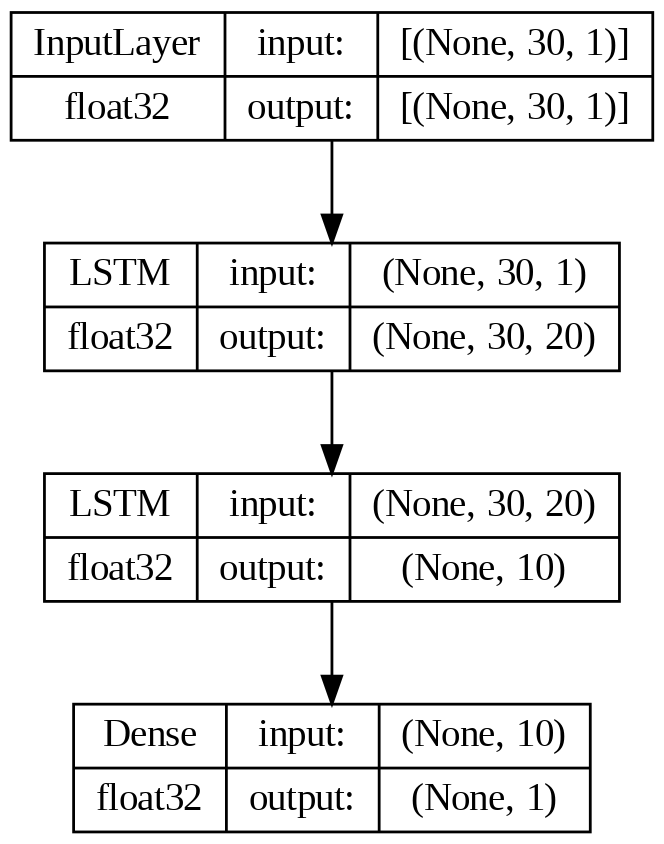

In [152]:
tf.keras.utils.plot_model(
    model,
    to_file='model.png',
    show_shapes=True,
    show_dtype=True,
    show_layer_names=False,
    rankdir='TB',
    expand_nested=False,
    dpi=200,
    show_layer_activations=False,
    show_trainable=False,
)

In [153]:
model.compile(loss = 'mse', optimizer = 'adam')
r = model.fit(x_train, y_train, validation_data=[x_test,y_test], epochs = 100)

Epoch 1/100
346/346 [==============================] - 12s 25ms/step - loss: 320.4301 - val_loss: 1272.8839
Epoch 2/100
346/346 [==============================] - 7s 20ms/step - loss: 229.4777 - val_loss: 1041.1061
Epoch 3/100
346/346 [==============================] - 8s 22ms/step - loss: 179.1202 - val_loss: 858.3516
Epoch 4/100
346/346 [==============================] - 7s 20ms/step - loss: 143.1794 - val_loss: 707.2870
Epoch 5/100
346/346 [==============================] - 8s 22ms/step - loss: 115.7041 - val_loss: 578.8583
Epoch 6/100
346/346 [==============================] - 8s 22ms/step - loss: 93.6636 - val_loss: 468.8312
Epoch 7/100
346/346 [==============================] - 7s 21ms/step - loss: 75.4630 - val_loss: 374.0438
Epoch 8/100
346/346 [==============================] - 8s 22ms/step - loss: 60.6700 - val_loss: 293.9870
Epoch 9/100
346/346 [==============================] - 7s 20ms/step - loss: 48.7529 - val_loss: 226.5860
Epoch 10/100
346/346 [=========================

# 5. Evaluation

In [154]:
trace1 = go.Scatter(x = list(range(0,len(r.history['loss']))), y=r.history['loss'], mode='lines', name='train loss')
trace2 = go.Scatter(x = list(range(0,len(r.history['val_loss']))), y=r.history['val_loss'], mode='lines', name='test loss')

# Combine traces into a single figure
fig = go.Figure()

# Add traces to the figure
fig.add_trace(trace1)
fig.add_trace(trace2)
fig.update_layout(title='Loss over epoch',
                  xaxis_title='epoch',
                  yaxis_title='loss')
fig.show()


## 5.1 Single Step Forecasting

The single-step prediction is a forecast for one day ahead and cannot be used to predict multiple days or future timesteps. In this example, it means that we use data from days 1, 2, 3, 4, 5 to predict only day 6.

In [155]:
y_predict_single = model.predict(x_test)

1/1 [==============================] - 1s 755ms/step


In [156]:
df.index[-30:]

DatetimeIndex(['2024-02-23', '2024-02-26', '2024-02-27', '2024-02-28',
               '2024-02-29', '2024-03-01', '2024-03-04', '2024-03-05',
               '2024-03-06', '2024-03-07', '2024-03-08', '2024-03-11',
               '2024-03-12', '2024-03-13', '2024-03-14', '2024-03-15',
               '2024-03-18', '2024-03-19', '2024-03-20', '2024-03-21',
               '2024-03-22', '2024-03-25', '2024-03-26', '2024-03-27',
               '2024-03-28', '2024-04-01', '2024-04-02', '2024-04-03',
               '2024-04-04', '2024-04-05'],
              dtype='datetime64[ns]', name='Date', freq=None)

In [157]:
trace1 = go.Scatter(x = df.index[-30:], y=y_test, mode='lines', name='actual price')
trace2 = go.Scatter(x = df.index[-30:], y=y_predict_single.reshape(30), mode='lines', name='predicted price')

# Combine traces into a single figure
fig = go.Figure()

# Add traces to the figure
fig.add_trace(trace1)
fig.add_trace(trace2)
fig.update_layout(title='actual vs predicted price',
                  xaxis_title='date',
                  yaxis_title='price')
fig.show()


In [158]:
mse = tf.keras.losses.MeanSquaredError()
mse(y_test, y_predict_single.reshape(30)).numpy()

2.3426378

## 5.2 Multi step prediction

Multi-step prediction allows for predicting more than one single step by utilizing the prediction results from the previous days. For example, using data from days 1, 2, 3, 4, 5, we can obtain the prediction for day 6. Then, by utilizing data from days 2, 3, 4, 5, along with the prediction result for day 6, we can obtain the prediction for day 7, and so forth. This enables predictions beyond a single step. However, the drawback of this method is that since it relies on previous prediction results for forecasting, errors from the previous predictions will accumulate, causing long-term predictions to deviate significantly from their actual values.

In [162]:
x_test.shape

(30, 30, 1)

In [163]:
y_pred_multi = []
x_terakhir = x_test[0]
counter = 0
while len(y_pred_multi) < len(y_test):
  pred = model.predict(x_terakhir.reshape(1,-1, 1))
  y_pred_multi.append(pred[0][0])
  #buat masukin hasil prediksi sebelumnya ke input
  x_terakhir = np.roll(x_terakhir,-1)
  x_terakhir[0][-1] = pred[0][0]
  counter +=1

1/1 [==============================] - 0s 26ms/step


In [164]:
trace1 = go.Scatter(x = df.index[-30:], y=y_test, mode='lines', name='actual price')
trace2 = go.Scatter(x = df.index[-30:], y=y_pred_multi, mode='lines', name='predicted price (multi)')

# Combine traces into a single figure
fig = go.Figure()

# Add traces to the figure
fig.add_trace(trace1)
fig.add_trace(trace2)
fig.update_layout(title='actual vs predicted price',
                  xaxis_title='date',
                  yaxis_title='price')
fig.show()
